In [4]:
import bt2
import sys
import pandas as pd

class EventList:
    def __init__(self):
        self.eventsByCpuId = {}

    def add(self, event):
        parts = event["name"].split("_")
        
        event_type = parts[0]
        event_name = parts[2]
        event_is_entry = parts[1] == "entry"

        if event_type != "syscall":
            return
        
        if not event["cpu_id"] in self.eventsByCpuId:
            self.eventsByCpuId[event["cpu_id"]] = {}


        if not event_name in self.eventsByCpuId[event["cpu_id"]]:
            self.eventsByCpuId[event["cpu_id"]][event_name] = {
                "entries": [],
                "exits": [],
                "spans": [],
            }

        num_entries = len(self.eventsByCpuId[event["cpu_id"]][event_name]["entries"])
        num_exits = len(self.eventsByCpuId[event["cpu_id"]][event_name]["exits"])

        if num_entries == num_exits and event_is_entry:
            self.eventsByCpuId[event["cpu_id"]][event_name]["entries"].append(event["timestamp"])
        elif num_entries > num_exits and not event_is_entry:
            self.eventsByCpuId[event["cpu_id"]][event_name]["exits"].append(event["timestamp"])
        elif num_entries > num_exits and event_is_entry:
            self.eventsByCpuId[event["cpu_id"]][event_name]["entries"].pop()
            self.eventsByCpuId[event["cpu_id"]][event_name]["entries"].append(event["timestamp"])
        elif event_is_entry:
            self.eventsByCpuId[event["cpu_id"]][event_name]["exits"].pop()

        num_exits = len(self.eventsByCpuId[event["cpu_id"]][event_name]["exits"])
        if num_entries != 0 and num_entries == num_exits:
            self.eventsByCpuId[event["cpu_id"]][event_name]["spans"].append(
                self.eventsByCpuId[event["cpu_id"]][event_name]["exits"][num_exits - 1] -
                self.eventsByCpuId[event["cpu_id"]][event_name]["entries"][num_entries - 1]
            )

    def flatten(self):
        eventsByName = {}

        for cpu_id in self.eventsByCpuId:
            for name in self.eventsByCpuId[cpu_id]:
                if name in eventsByName:
                    eventsByName[name]["entries"] = eventsByName[name]["entries"] + self.eventsByCpuId[cpu_id][name]["entries"]
                    eventsByName[name]["exits"] = eventsByName[name]["exits"] + self.eventsByCpuId[cpu_id][name]["exits"]
                    eventsByName[name]["spans"] = eventsByName[name]["spans"] + self.eventsByCpuId[cpu_id][name]["spans"]
                else:
                    eventsByName[name] = {
                        "entries": self.eventsByCpuId[cpu_id][name]["entries"],
                        "exits": self.eventsByCpuId[cpu_id][name]["exits"],
                        "spans": self.eventsByCpuId[cpu_id][name]["spans"]
                    }

        return eventsByName

    def average_durations(self):
        durations = {}
        flattened_event_list = self.flatten()
        
        for name in flattened_event_list:
            average = sum(flattened_event_list[name]["spans"]) / len(flattened_event_list[name]["spans"])
            durations[name] = average

        return durations

In [1]:
# Create a map of syscalls
syscalls = [] 

# Create a trace collection message iterator with this path.
msg_it = bt2.TraceCollectionMessageIterator("traces/example")

# Last event's time (ns from origin).
last_event_ns_from_origin = None

event_list = EventList()

# Iterate the trace messages.
for idx, msg in enumerate(msg_it):
    if idx == 1000:
        break
    # `bt2._EventMessageConst` is the Python type of an event message.
    if type(msg) is bt2._EventMessageConst:
        event = {
            "cpu_id": msg.event["cpu_id"],
            "name": msg.event.name,
            "timestamp": msg.default_clock_snapshot.ns_from_origin
        }
        event_list.add(event)

event_list_flattened = event_list.flatten()

df_event_list_flattened = pd.DataFrame.from_records(event_list_flattened)
print(df_event_list_flattened)

                                                     epoll  \
entries  [1689706166884938288, 1689706166883063763, 168...   
exits           [1689706166883066813, 1689706166883359061]   
spans                             [3050, 3050, 2300, 2300]   

                                                 fadvise64  \
entries  [1689706166889303565, 1689706166889423892, 168...   
exits    [1689706166889313709, 1689706166889437401, 168...   
spans    [10144, 10144, 13509, 13509, 11116, 11116, 368...   

                                                     futex  \
entries  [1689706166881950277, 1689706166881970916, 168...   
exits    [1689706166881952062, 1689706166883997632, 168...   
spans    [1785, 1785, 2026716, 2026716, 3402, 3402, 911...   

                                                    getpid  \
entries  [1689706166882181558, 1689706166882211668, 168...   
exits    [1689706166882183328, 1689706166882212803, 168...   
spans                       [1770, 1770, 1135, 1135, 1034]   

    

In [2]:
averages = event_list.average_durations()
df_event_list_averages = pd.DataFrame.from_records(averages, index=['1'])
print(df_event_list_averages)

    epoll    fadvise64          futex  getpid        ioctl     mmap  \
1  2675.0  3712.815385  536062.909091  1368.8  4698.932939  41603.0   

            poll         read      recvmsg       sendmsg         sync  \
1  154967.068182  2777.576923  3569.035088  13540.571429  9684.320611   

       unknown        write   writev  
1  3318.333333  7455.075269  16210.0  


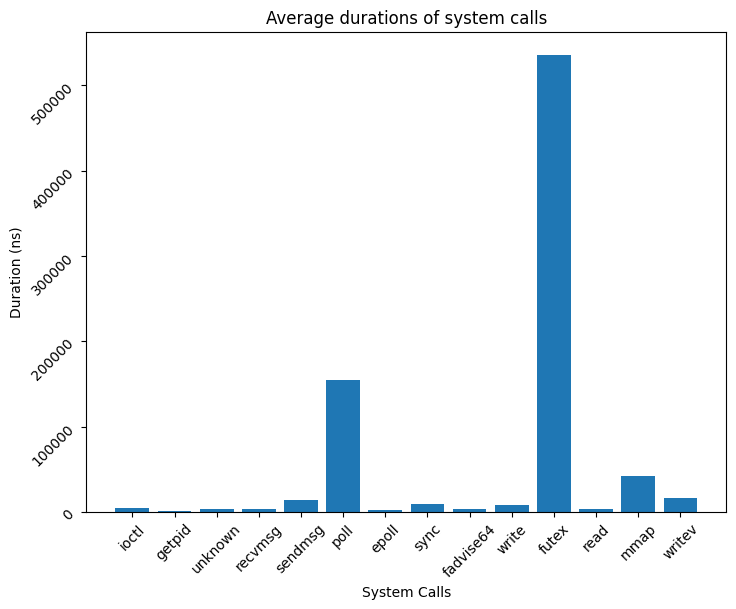

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average durations of system calls')
events = averages.keys()
durations = averages.values()
ax.bar(events,durations)
plt.xlabel('System Calls')
plt.xticks(rotation = 45)
plt.ylabel('Duration (ns)')
plt.yticks(rotation=45)
plt.show()